In [9]:
# Import necessary libraries
import json
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta
from typing import Dict, Any, List, Tuple
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import gte, gt, within, between
import nest_asyncio
import warnings

# Configure Jupyter Notebook compatibility
warnings.filterwarnings('ignore')
nest_asyncio.apply()

# Define the Enhanced AML System class
class EnhancedAMLSystem:
    """Enhanced Anti-Money Laundering Detection System with Visualization"""

    def __init__(self, neptune_endpoint: str):
        """Initialize the AML system with Neptune connection"""
        self.neptune_endpoint = neptune_endpoint
        self.graph = Graph()
        self.g = None

    def _get_traversal(self):
        """Get or create graph traversal"""
        if self.g is None:
            self.g = self.graph.traversal().withRemote(
                DriverRemoteConnection(self.neptune_endpoint, 'g')
            )
        return self.g

    def generate_synthetic_data(self, num_accounts: int = 100, num_transactions: int = 500) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Generate synthetic accounts and transactions"""
        accounts = []
        transactions = []

        # Generate accounts
        for i in range(num_accounts):
            account = {
                'account_id': f'ACC_{i}',
                'country': np.random.choice(['US', 'UK', 'CA', 'IN', 'CN', 'RU']),
                'risk_score': np.random.rand(),
                'created_date': datetime.now() - timedelta(days=np.random.randint(30, 365))
            }
            accounts.append(account)

        # Generate transactions
        for i in range(num_transactions):
            source = np.random.choice(accounts)
            destination = np.random.choice(accounts)
            while destination['account_id'] == source['account_id']:
                destination = np.random.choice(accounts)

            transaction = {
                'transaction_id': f'TXN_{i}',
                'source_account': source['account_id'],
                'destination_account': destination['account_id'],
                'amount': np.random.uniform(10, 10000),
                'timestamp': datetime.now() - timedelta(days=np.random.randint(1, 30))
            }
            transactions.append(transaction)

        return pd.DataFrame(accounts), pd.DataFrame(transactions)

    def visualize_entity_relationship(self, transactions: pd.DataFrame):
        """Visualize entity relationships with color coding"""
        G = nx.DiGraph()
        for _, txn in transactions.iterrows():
            G.add_edge(txn['source_account'], txn['destination_account'], weight=txn['amount'])

        pos = nx.spring_layout(G)
        fig, ax = plt.subplots(figsize=(12, 8))

        # Color-code nodes
        node_colors = ['#FF5733' if 'ACC_' in node else '#33FF57' for node in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, alpha=0.8, ax=ax)

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
        ax.set_title("Entity Relationship Graph (Color-coded)")
        plt.show()

    def visualize_clusters(self, clusters: List):
        """Visualize suspicious clusters with color coding"""
        if not clusters:
            print("No clusters to visualize.")
            return

        df = pd.DataFrame(clusters)
        fig = px.bar(df, x='country', y='transaction_count', color='transaction_count',
                     title="Suspicious Clusters by Country",
                     color_continuous_scale='Viridis')
        fig.show()

    def visualize_transaction_flows(self, transactions: pd.DataFrame):
        """Visualize transaction flows with color coding"""
        numeric_transactions = transactions.drop(columns=['timestamp'], errors='ignore')
        df = numeric_transactions.groupby(['source_account', 'destination_account']).sum().reset_index()
        unique_accounts = list(set(df['source_account']).union(set(df['destination_account'])))
        account_indices = {account: idx for idx, account in enumerate(unique_accounts)}

        # Add colors to nodes
        node_colors = ['rgba(255, 87, 51, 0.8)' if 'ACC_' in node else 'rgba(51, 255, 87, 0.8)' for node in unique_accounts]

        fig = go.Figure(go.Sankey(
            node=dict(
                label=unique_accounts,
                pad=15,
                thickness=20,
                color=node_colors
            ),
            link=dict(
                source=df['source_account'].map(account_indices),
                target=df['destination_account'].map(account_indices),
                value=df['amount']
            )
        ))
        fig.update_layout(title_text="Transaction Flows (Color-coded)", font_size=10)
        fig.show()

    def visualize_risk_scores(self, accounts: pd.DataFrame):
        """Visualize risk score distribution with color-coded bars"""
        plt.figure(figsize=(10, 6))
        n, bins, patches = plt.hist(accounts['risk_score'], bins=10, color='gray', edgecolor='black')

        # Apply color gradient
        for i, patch in enumerate(patches):
            plt.setp(patch, 'facecolor', plt.cm.viridis(i / len(patches)))

        plt.title("Risk Score Distribution (Color-coded)")
        plt.xlabel("Risk Score")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    def visualize_circular_transactions(self, transactions: pd.DataFrame):
        """Visualize circular transaction patterns with color coding"""
        G = nx.DiGraph()
        for _, txn in transactions.iterrows():
            G.add_edge(txn['source_account'], txn['destination_account'])

        pos = nx.circular_layout(G)
        fig, ax = plt.subplots(figsize=(10, 6))

        # Assign colors to nodes and edges
        node_colors = ['#FF5733' if 'ACC_' in node else '#33FF57' for node in G.nodes()]
        edge_colors = ['#FFBD33' for _ in G.edges()]

        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=700, edge_color=edge_colors, ax=ax)
        ax.set_title("Circular Transactions (Color-coded)")
        plt.show()

    def visualize_geographic_distribution(self, accounts: pd.DataFrame):
        """Visualize geographic distribution with a color-coded heatmap"""
        df = accounts.groupby('country').size().reset_index(name='transaction_count')
        fig = px.choropleth(df, locations='country', locationmode='ISO-3', color='transaction_count',
                            title="Geographic Distribution of Accounts",
                            color_continuous_scale='Plasma')
        fig.show()

    def visualize_time_series(self, transactions: pd.DataFrame):
        """Visualize transaction activity over time with color-coded lines"""
        transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])
        grouped = (
            transactions.groupby(transactions['timestamp'].dt.date)
            .agg({'amount': 'sum'})
            .reset_index()
        )

        plt.figure(figsize=(10, 6))
        plt.plot(grouped['timestamp'], grouped['amount'], marker='o', color='#FF5733', label='Transaction Amount')
        plt.title("Transaction Activity Over Time (Color-coded)")
        plt.xlabel("Date")
        plt.ylabel("Total Amount")
        plt.grid(True)
        plt.legend()
        plt.show()

    def test_visualizations(self):
        """Run all visualizations using synthetic data"""
        accounts, transactions = self.generate_synthetic_data(num_accounts=50, num_transactions=100)
        print("Testing Visualizations...")

        print("Visualizing Entity Relationships...")
        self.visualize_entity_relationship(transactions)

        print("Visualizing Clusters...")
        clusters = [{'country': row['country'], 'transaction_count': np.random.randint(1, 20)} for _, row in accounts.iterrows()]
        self.visualize_clusters(clusters)

        print("Visualizing Transaction Flows...")
        self.visualize_transaction_flows(transactions)

        print("Visualizing Risk Scores...")
        self.visualize_risk_scores(accounts)

        print("Visualizing Circular Transactions...")
        self.visualize_circular_transactions(transactions)

        print("Visualizing Geographic Distribution...")
        self.visualize_geographic_distribution(accounts)

        print("Visualizing Time Series...")
        self.visualize_time_series(transactions)

        print("All visualizations tested.")

Testing Visualizations...
Visualizing Entity Relationships...


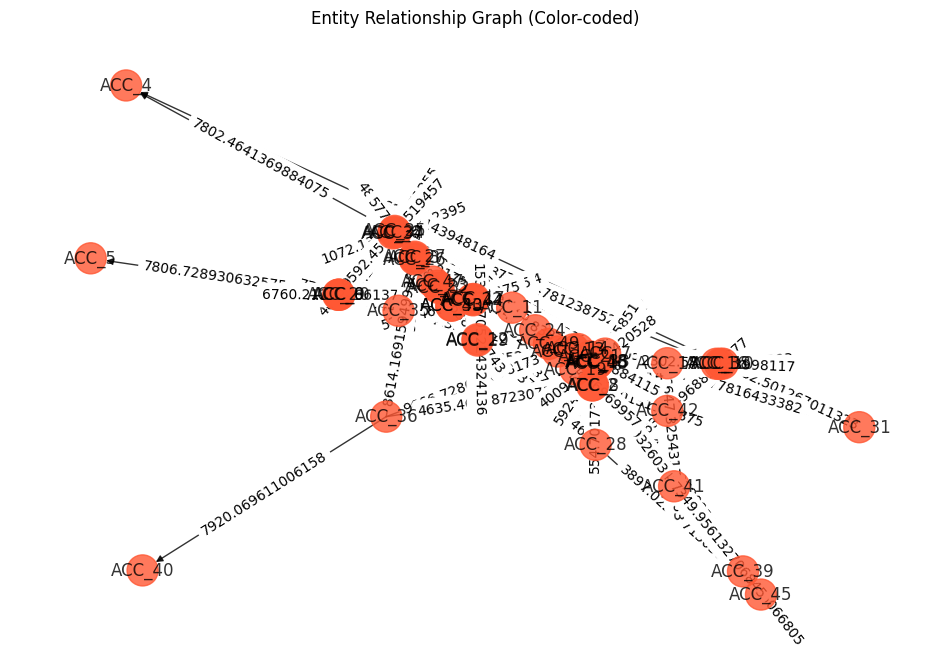

Visualizing Clusters...


Visualizing Transaction Flows...


Visualizing Risk Scores...


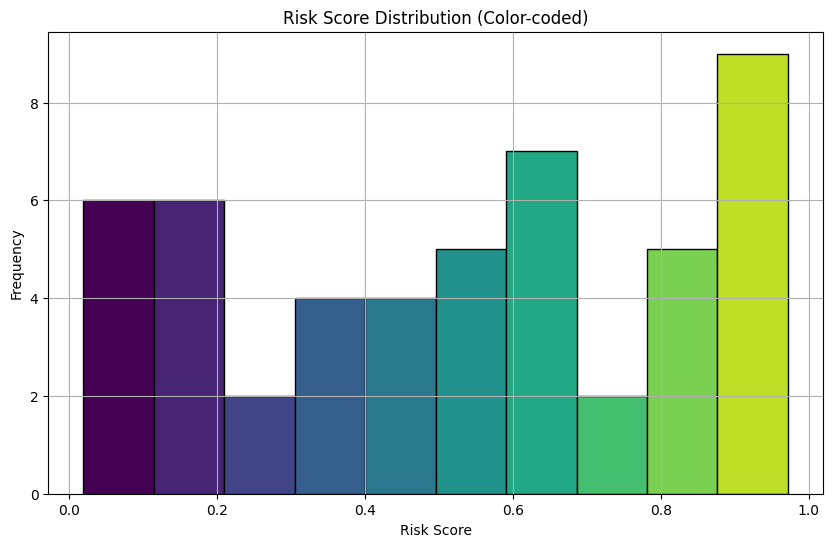

Visualizing Circular Transactions...


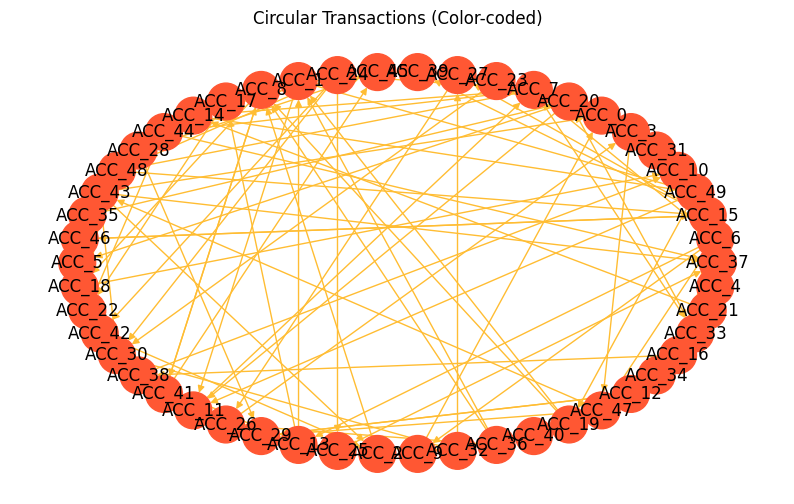

Visualizing Geographic Distribution...


Visualizing Time Series...


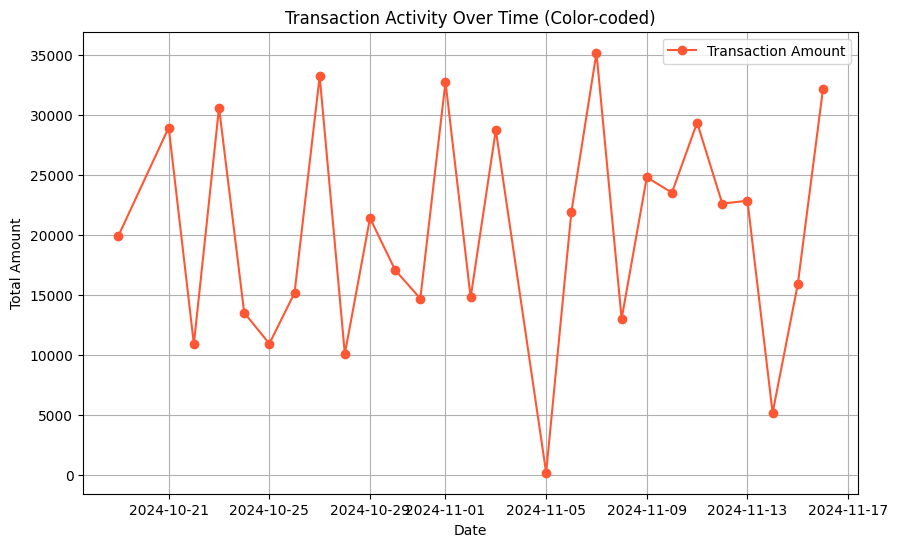

All visualizations tested.


In [10]:
neptune_endpoint = "wss://neptunedbcluster-ovklzbmd7ywv.cluster-ctij9o7ncbvq.us-east-1.neptune.amazonaws.com:8182/gremlin"

aml_system = EnhancedAMLSystem(neptune_endpoint)

aml_system.test_visualizations()
